<a href="https://colab.research.google.com/github/CassDabii/BBC-DS-Task/blob/main/BBC_DSProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***BBC Data Science Project*** 
---
Since this project is open ended it is up to me to determine what data is useful to make actionable insights. To do this I will make a list of *preliminary* goals that are variable, however any goals added or omitted will not be hidden but instead justified to maintain credibility




Goals
*   Determine the effect weather has on the length of the journey and the cycle volume.
*   Determine the usefulness and performance of trying to predict cycle volumes
*   Decipher where to add another station
*   If the business was ever wanting to get rid of a station what station would make the most sense to get rid of.
*   What effect bike station capacity has (e.g., the more spaces the more people go use it).
*   Which stations would it be useful to expand.












## Acquiring Data

In [82]:
# All imports declared at top cell to have a centralised location if changes are needed
import pandas as pd
import matplotlib.pyplot  as plt
%matplotlib inline
import numpy as np
import sqlite3 

In [48]:
# Connects to my uploaded database and creates a cursor object to execute SQL statements when needed
conn = sqlite3.connect('/content/BBCDS.sqlite3')

cursor = conn.cursor()

In [49]:
# Reads the database tables and writes it into a dataframe
bike_journeys = pd.read_sql('SELECT * FROM bike_journeys;',conn)
bike_stations = pd.read_sql('SELECT * FROM bike_stations;',conn)
weather = pd.read_sql('SELECT * FROM weather;',conn)

### Bike Journeys

***COLUMNS ARE MISSING FROM THE DATABASE BECAUSE LATER(UNDER THE BIKE JOURNE) I DROP SOME COLUMNS ***

In [50]:
# Shows the data in a dataframe format
bike_journeys 

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID
0,2040,953,19,9,17,18,0,478,19,9,17,17,26,251
1,1800,12581,19,9,17,15,21,122,19,9,17,14,51,550
2,1140,1159,15,9,17,17,1,639,15,9,17,16,42,212
3,420,2375,14,9,17,12,16,755,14,9,17,12,9,163
4,1200,14659,13,9,17,19,33,605,13,9,17,19,13,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542839,270,5296,8,8,17,0,2,32,7,8,17,23,58,42
1542840,911,12348,8,8,17,0,13,625,7,8,17,23,58,222
1542841,447,8303,8,8,17,0,7,453,7,8,17,23,59,130
1542842,424,12038,8,8,17,0,6,405,7,8,17,23,59,755


Looking over the data, that the lowest change in the time series is minutes: However, cross referenceing with the other columns show that the journey duration is given in seconds so that will have to be changed since that inconsistency lowers the data quality. I also see that some journeys have the same ID so its purpose as a primary key has failed. My initial thoughts are that the data needs a lot of TLC and quality is low due to over use of columns for date and time and no Primary Key. 

In [51]:
# Shows the data type for each feature/varible
bike_journeys.dtypes 

Journey Duration    int64
Journey ID          int64
End Date            int64
End Month           int64
End Year            int64
End Hour            int64
End Minute          int64
End Station ID      int64
Start Date          int64
Start Month         int64
Start Year          int64
Start Hour          int64
Start Minute        int64
Start Station ID    int64
dtype: object

Since these are all numerical I am thinking the use of the .corr() will be useful and there may be a vast range of data visualisations.

### Bike Stations

In [52]:
bike_stations

,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"
3,4,23,51.530059,-0.120973,"St. Chad's Street, King's Cross"
4,5,27,51.493130,-0.156876,"Sedding Street, Sloane Square"
...,...,...,...,...,...
768,190,21,51.489975,-0.132845,"Rampayne Street, Pimlico"
769,194,56,51.504627,-0.091773,"Hop Exchange, The Borough"
770,195,30,51.507244,-0.106237,"Milroy Walk, South Bank"
771,196,17,51.503688,-0.098497,"Union Street, The Borough"


I can already see that the Station ID can is a foreign key between bike stations and bike journeys. I am expecting to use a join to get all the data in one flat table.

In [53]:
bike_stations.dtypes

Station ID        int64
Capacity          int64
Latitude        float64
Longitude       float64
Station Name     object
dtype: object

### Weather

In [54]:
weather.head()

,LATITUDE,LONGITUDE,DATE,PRCP (MM),TAVG (CELSIUS)
0,51.478,-0.461,01/08/2017,0.0,17.1
1,51.478,-0.461,02/08/2017,0.8,16.8
2,51.478,-0.461,03/08/2017,7.1,18.4
3,51.478,-0.461,04/08/2017,0.0,18.3
4,51.478,-0.461,05/08/2017,0.0,16.8


The way the date is formated in this dataset differs from the bike journeys data set so this will have to be changed so I can join these datasets. Also this dataset includes dates from august when all of the bike journeys take place in september so that will be omitted as it is not needed. Also, this data only tells of the weather in one area and tells us the precipitation and temperature for the day not detailing wether it was the average or the highest respective values for that day and not giving specific times.

In [55]:
weather.dtypes

LATITUDE          float64
LONGITUDE         float64
DATE               object
PRCP (MM)         float64
TAVG (CELSIUS)    float64
dtype: object

## Prepare

In [56]:
# The use of these 2 methods together checks if there are missing values in any of the columns
bike_journeys.isnull().any() 

Journey Duration    False
Journey ID          False
End Date            False
End Month           False
End Year            False
End Hour            False
End Minute          False
End Station ID      False
Start Date          False
Start Month         False
Start Year          False
Start Hour          False
Start Minute        False
Start Station ID    False
dtype: bool

Initally I want to check if there are any missing data in any of the columns since it could most probably be lowering the data quality. However, other alternatives to just droping the rows of data could be looked into.Depending on factors such as where the missing data lies (e.g, if the station ID's are missing that is major factor for the outcomes but if the start hour is missing but there is still the journey duration the data could be filled.) this also depends on how much missing data there is could tell me if it worth going through these changes.

In [57]:
bike_stations.isnull().any()

Station ID      False
Capacity        False
Latitude        False
Longitude       False
Station Name    False
dtype: bool

In [58]:
weather.isnull().any()

LATITUDE          False
LONGITUDE         False
DATE              False
PRCP (MM)         False
TAVG (CELSIUS)    False
dtype: bool

### Bike Journey and Stations Preparations

In [59]:
# Joins the bike_journeys and bike_stations tables using the Station ID's
journey_station = pd.read_sql('''SELECT *
               FROM bike_journeys
               JOIN bike_stations ON bike_journeys.[Start Station ID] = bike_stations.[Station ID]''',conn)
journey_station

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID,Station ID,Capacity,Latitude,Longitude,Station Name
0,2040,953,19,9,17,18,0,478,19,9,17,17,26,251,251,34,51.518908,-0.079249,"Brushfield Street, Liverpool Street"
1,1800,12581,19,9,17,15,21,122,19,9,17,14,51,550,550,23,51.521564,-0.039264,"Harford Street, Mile End"
2,1140,1159,15,9,17,17,1,639,15,9,17,16,42,212,212,17,51.506584,-0.199004,"Campden Hill Road, Notting Hill"
3,420,2375,14,9,17,12,16,755,14,9,17,12,9,163,163,27,51.493184,-0.167894,"Sloane Avenue, Knightsbridge"
4,1200,14659,13,9,17,19,33,605,13,9,17,19,13,36,36,28,51.501737,-0.184980,"De Vere Gardens, Kensington"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530235,270,5296,8,8,17,0,2,32,7,8,17,23,58,42,42,28,51.530991,-0.093903,"Wenlock Road , Hoxton"
1530236,911,12348,8,8,17,0,13,625,7,8,17,23,58,222,222,43,51.502757,-0.155349,"Knightsbridge, Hyde Park"
1530237,447,8303,8,8,17,0,7,453,7,8,17,23,59,130,130,24,51.509506,-0.075459,"Tower Gardens , Tower"
1530238,424,12038,8,8,17,0,6,405,7,8,17,23,59,755,755,24,51.485121,-0.174971,"The Vale, Chelsea"


I join the bike journeys and bike stations tables to have all the data in one flat table so I can use methods like .corr and or visualise correlations and other statistical methods. I know that I will have to join the weather dataset at somee point but there isn't a give column to perform a join. A merge using pandas is posible but I will have to cross reference manually which will take longer so I write a SQL script in the sqlite3 interface that turns the date columns into the date format DD/MM/YYYY and drop the columns that are now uneccessary. Also if I am formatting the date it would make the data more clean to format the times also.




**Adds the columns to the table**
```
ALTER TABLE bike_journeys_formatted ADD COLUMN formatted_start_date TEXT;
ALTER TABLE bike_journeys_formatted ADD COLUMN formatted_end_date TEXT;
ALTER TABLE bike_journeys_formatted ADD COLUMN start_time TEXT;
ALTER TABLE bike_journeys_formatted ADD COLUMN end_time TEXT;
```



**This uses the columns to make the date in the DD/MM/YYYY format and if the month or date is a single character it adds 0 to the front. 2000 is added to the year to fit the format.**
```
UPDATE bike_journeys_formatted
SET formatted_start_date = CASE
  WHEN LENGTH("Start Date") = 1 AND LENGTH("Start Month") = 1 THEN '0'||"Start Date"||'/0'||"Start Month"||'/'||("Start Year"+2000)
  WHEN LENGTH("Start Date") = 1 THEN '0'||"Start Date"||'/'||"Start Month"||'/'||("Start Year"+2000)
  WHEN LENGTH("Start Month") = 1 THEN "Start Date"||'/0'||"Start Month"||'/'||("Start Year"+2000)
  ELSE "Start Date"||'/'||"Start Month"||'/'||("Start Year"+2000)
END,
formatted_end_date = CASE
  WHEN LENGTH("End Date") = 1 AND LENGTH("End Month") = 1 THEN '0'||"End Date"||'/0'||"End Month"||'/'||("End Year"+2000)
  WHEN LENGTH("End Date") = 1 THEN '0'||"End Date"||'/'||"End Month"||'/'||("End Year"+2000)
  WHEN LENGTH("End Month") = 1 THEN "End Date"||'/0'||"End Month"||'/'||("End Year"+2000)
  ELSE "End Date"||'/'||"End Month"||'/'||("End Year"+2000)
END;

```
**The times are formatted to HH:MM using the respective Hour and Minute columns**



```
# UPDATE bike_journeys_formatted
SET end_time = CASE
                WHEN "End Hour" < 10 THEN '0'||"End Hour"
                ELSE "End Hour"
              END
              || ':'
              || CASE
                   WHEN "End Minute" < 10 THEN '0'||"End Minute"
                   ELSE "End Minute"
                 END,
    start_time = CASE
                  WHEN "Start Hour" < 10 THEN '0'||"Start Hour"
                  ELSE "Start Hour"
                END
                || ':'
                || CASE
                     WHEN "Start Minute" < 10 THEN '0'||"Start Minute"
                     ELSE "Start Minute"
                   END;
```







**Then the old columns are dropped**

```
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Date";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Month";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Year";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Date";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Month";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Year";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Hour";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Minute";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Hour";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Minute";
```









### Weather Preparation

In [60]:
# Check the row where the weather has the exact same latitude and logitude 
pd.read_sql('''SELECT * 
                FROM bike_stations
                WHERE [Latitude] = "51.478" AND [Longitude] = "-0.461"
                ;''', conn) 

,Station ID,Capacity,Latitude,Longitude,Station Name


There is no row with this exact latitdue and logitude so I have to check how close the nearest station is to this point and if the distance is large enough to disregard the weather data. 

In [65]:
# This query shows orders the closest station to the furtherst station from the given longitude and latitude 
pd.read_sql('''SELECT *
                FROM bike_stations
                ORDER BY ABS([Latitude] - 51.478) + ABS([Longitude] + 0.461)
                ;''', conn)


,Station ID,Capacity,Latitude,Longitude,Station Name
0,668,26,51.494223,-0.236769,"Ravenscourt Park Station, Hammersmith"
1,753,28,51.492636,-0.234094,"Hammersmith Town Hall, Hammersmith"
2,644,36,51.483732,-0.223852,"Rainville Road, Hammersmith"
3,682,46,51.488108,-0.226606,"Crisp Road, Hammersmith"
4,599,28,51.485743,-0.223616,"Manbre Road, Hammersmith"
...,...,...,...,...,...
768,785,64,51.540940,-0.010510,"Aquatic Centre, Queen Elizabeth Olympic Park"
769,787,35,51.546805,-0.014691,"Timber Lodge, Queen Elizabeth Olympic Park"
770,786,44,51.549369,-0.015717,"Lee Valley VeloPark, Queen Elizabeth Olympic Park"
771,784,34,51.546326,-0.009935,"East Village, Queen Elizabeth Olympic Park"


Using an online google maps I calculated the distance to the furthest station and the given longitude and latitude in the weather dataset (20.11 miles). This still falls under the london GPE so the weather could be taken under consideration with every journey. The time not being a part of of the date is still an issue.

In [108]:
#Joins all three datasets
combined_data = pd.read_sql('''SELECT *
                               FROM bike_journeys_formatted
                               JOIN bike_stations ON bike_journeys_formatted.[Start Station ID] = bike_stations.[Station ID]
                               JOIN weather ON bike_journeys_formatted.formatted_start_date = weather.DATE;
                               ''', conn)
# Removes irrelevant columns
combined_data = combined_data.drop(columns=["DATE", "LONGITUDE", "LATITUDE"])
# Changes journey duration measurement from seconds to minutes
combined_data['Journey Duration'] = combined_data['Journey Duration'] / 60
# Turns columns to lowercase and use underscores instead of spaces
combined_data.columns = [c.replace(' ', '_').lower() for c in combined_data.columns]
combined_data

,journey_duration,journey_id,end_hour,end_minute,end_station_id,start_hour,start_minute,start_station_id,formatted_start_date,formatted_end_date,station_id,capacity,latitude,longitude,station_name,prcp_(mm),tavg_(celsius)
0,20.000000,14659,19,33,605,19,13,36,13/09/2017,13/09/2017,36,28,51.501737,-0.184980,"De Vere Gardens, Kensington",2.5,14.8
1,15.000000,9923,8,32,298,8,17,154,13/09/2017,13/09/2017,154,35,51.503791,-0.112824,"Waterloo Station 3, Waterloo",2.5,14.8
2,8.000000,9642,15,31,194,15,23,156,13/09/2017,13/09/2017,156,33,51.494436,-0.092921,"New Kent Road, The Borough",2.5,14.8
3,8.000000,12668,15,31,194,15,23,156,13/09/2017,13/09/2017,156,33,51.494436,-0.092921,"New Kent Road, The Borough",2.5,14.8
4,11.000000,8907,8,42,368,8,31,307,13/09/2017,13/09/2017,307,24,51.509908,-0.187842,"Black Lion Gate, Kensington Gardens",2.5,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353589,4.500000,5296,0,2,32,23,58,42,07/08/2017,08/08/2017,42,28,51.530991,-0.093903,"Wenlock Road , Hoxton",0.0,16.7
1353590,15.183333,12348,0,13,625,23,58,222,07/08/2017,08/08/2017,222,43,51.502757,-0.155349,"Knightsbridge, Hyde Park",0.0,16.7
1353591,7.450000,8303,0,7,453,23,59,130,07/08/2017,08/08/2017,130,24,51.509506,-0.075459,"Tower Gardens , Tower",0.0,16.7
1353592,7.066667,12038,0,6,405,23,59,755,07/08/2017,08/08/2017,755,24,51.485121,-0.174971,"The Vale, Chelsea",0.0,16.7


### Check Data Quality

In [80]:
# Returns the number of duplicate rows
combined_data.duplicated().sum()

6

The likleyhood of an individual having the same values for each column is extremley low and since there is only 6 out of more than a million gives a stong rationale that this is an administrative error so they can just be removed.

In [ ]:
# Remove the duplicate rows
combined_data.drop_duplicates(inplace=True)

In [104]:
# Remove the journeys that have a 0 journey duration
combined_data = combined_data[combined_data.['Journey Duration'] < 0.1]



SyntaxError: ignored

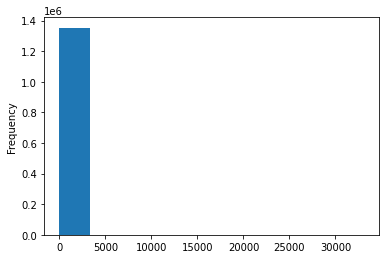

In [92]:
combined_data['Journey Duration'].plot.hist()

The histogram is not very informative becuase there are a small amount that have a wide variance in journey duration. This could be due many reasons but ultimatley the individuals not going to ending bike station for a long time.

In [94]:
combined_data['Journey Duration'].describe()

count    1.353594e+06
mean     2.247946e+01
std      1.165674e+02
min      0.000000e+00
25%      8.550000e+00
50%      1.426667e+01
75%      2.263333e+01
max      3.307833e+04
Name: Journey Duration, dtype: float64

In [90]:
# Check the number of and the information of the rows that had a journey duration over 5 hours
outlier_Journeys=combined_data[combined_data['Journey Duration']>= 300]


I chose the journey duration to check for and exclude based on what was an considered an outlier.

Now all the datasets have been combined and prepared for analysis and modelling.

## Analyse


### 1. Affect of Weather



In [76]:
# Select the columns of interest from the combined data
weather_columns = ['PRCP (MM)', 'TAVG (CELSIUS)']
duration_column = 'Journey Duration'
selected_data = combined_data[weather_columns + [duration_column]]

# Calculate the correlation matrix
correlation_matrix = selected_data.corr()

# Print the correlation coefficients
print(correlation_matrix[duration_column])

PRCP (MM)          -0.002504
TAVG (CELSIUS)      0.000161
Journey Duration    1.000000
Name: Journey Duration, dtype: float64
